# LSTM Modelling 

In [8]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

## Data Refactor

In [9]:
dataset = pd.read_csv("./StationDateDatasets/datasetStationDate.csv").drop(columns=["Unnamed: 0"])

In [10]:
trips = pd.read_csv("./CSVFiles/datatrips.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips = trips.drop(columns=["DateEnd"])
trips["Day"] = day
trips["Year"] = year

In [11]:
new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "Workingday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in dataset.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = df

dataset = dataset.join(new_data)

In [ ]:
dataset.to_csv("./StationDateDatasets/datasetStationDate.csv")

## Correlation Features

In [ ]:
def featureSelect_dataframe(X, y, criteria, k):

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X, reg.scores_

X = dataset[[col for col in dataset.columns if "Count" not in col]]
y = dataset['Count']

new_x_data = []

# F-value between label/feature for regression tasks.
New_X, scoresX = featureSelect_dataframe(X, y, f_regression, 11)
new_x_data_1 = {list(X.columns)[x]:scoresX[x] for x in range(0,len(list(X.columns)))}
pprint(sorted(new_x_data_1.items(), key=lambda x:x[1], reverse=True))

[('Temp', 7205.982784325835),
 ('ATemp', 7063.421517473056),
 ('Humidity', 5255.337139434859),
 ('Year', 4834.585429696891),
 ('Hour', 2623.344788510026),
 ('WeatherSituation', 1517.5650872735619),
 ('Windspeed', 305.6184488006753),
 ('StationEnd', 217.14764163333265),
 ('Day', 104.26113540122923),
 ('Workingday', 68.07180660262784),
 ('Weekday', 48.78056977774858),
 ('Holiday', 48.33766490366175)]


## LSTM

In [ ]:
epochs = 10
batch_size = 1
verbose = 2

### Method 0
Input: c(t), StationEnd

Output: c(t+1)

In [35]:
print("""
--------------------------------------------------------------------------------------------

METHOD 0:
Input: c(t), StationEnd
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):

  model_met1 = Sequential()
  model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
  model_met1.add(Dense(1))
  model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

  history = model_met1.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=verbose)

  # Generate generalization metrics
  scores = model_met1.evaluate(X[test], y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model_met1.metrics_names[0]} of {scores[0]}; {model_met1.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1


--------------------------------------------------------------------------------------------

METHOD 0:
Input: c(t), StationEnd
Output: c(t+1)


Epoch 1/10


2023-05-09 10:00:40.462925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 10:00:40.463931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 10:00:40.464576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

61129/61129 - 51s - loss: 2.7899 - 51s/epoch - 828us/step
Epoch 2/10
61129/61129 - 51s - loss: 2.6713 - 51s/epoch - 838us/step
Epoch 3/10
61129/61129 - 53s - loss: 2.6658 - 53s/epoch - 859us/step
Epoch 4/10
61129/61129 - 50s - loss: 2.6635 - 50s/epoch - 823us/step
Epoch 5/10
61129/61129 - 48s - loss: 2.6576 - 48s/epoch - 780us/step
Epoch 6/10
61129/61129 - 52s - loss: 2.6561 - 52s/epoch - 844us/step
Epoch 7/10
61129/61129 - 53s - loss: 2.6551 - 53s/epoch - 865us/step
Epoch 8/10
61129/61129 - 55s - loss: 2.6513 - 55s/epoch - 905us/step
Epoch 9/10
61129/61129 - 48s - loss: 2.6532 - 48s/epoch - 784us/step
Epoch 10/10
61129/61129 - 49s - loss: 2.6499 - 49s/epoch - 793us/step
 174/1911 [=>............................] - ETA: 1s

2023-05-09 10:09:09.276479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 10:09:09.277666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 10:09:09.278413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

554/554 [==============================] - 0s 553us/step
Train Score: 2.63 MSE
Test Score: 3.22 MSE


Text(0.5, 0, 'Methods')

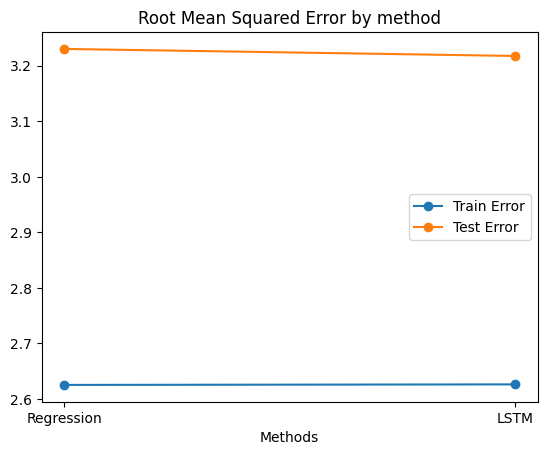

In [36]:
plt.plot(["Regression", "LSTM"], [2.62536746, 2.63], marker="o")
plt.plot(["Regression", "LSTM"], [3.23016036, 3.22], marker="o")
plt.legend(["Train Error", "Test Error"])
plt.title("Root Mean Squared Error by method")
plt.xlabel("Methods")

### Method 1
Input: c(t), StationEnd, Temp

Output: c(t+1)

In [16]:
print("""
--------------------------------------------------------------------------------------------

METHOD 1:
Input: c(t), StationEnd, Temp
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp"]

training_data_met1 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met1 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met1.drop(columns=["Count"])
trainY = training_data_met1["Count"]

testX = testing_data_met1.drop(columns=["Count"])
testY = testing_data_met1["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,training_data_met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met1, testing_data_met1]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = mean_squared_error(trainY[:], trainPredict[:])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(testY[:], testPredict[:])
print('Test Score: %.2f MSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 1:
Input: c(t), StationEnd, Temp
Output: c(t+1)


Epoch 1/10


2023-05-08 16:05:40.904471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 16:05:40.906347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 16:05:40.907489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

61129/61129 - 55s - loss: 2.7711 - 55s/epoch - 900us/step
Epoch 2/10
61129/61129 - 55s - loss: 2.6488 - 55s/epoch - 902us/step
Epoch 3/10
61129/61129 - 52s - loss: 2.6348 - 52s/epoch - 850us/step
Epoch 4/10
61129/61129 - 52s - loss: 2.6311 - 52s/epoch - 857us/step
Epoch 5/10
61129/61129 - 52s - loss: 2.6242 - 52s/epoch - 857us/step
Epoch 6/10
61129/61129 - 52s - loss: 2.6199 - 52s/epoch - 850us/step
Epoch 7/10
61129/61129 - 49s - loss: 2.6160 - 49s/epoch - 803us/step
Epoch 8/10
61129/61129 - 47s - loss: 2.6123 - 47s/epoch - 770us/step
Epoch 9/10
61129/61129 - 47s - loss: 2.6084 - 47s/epoch - 771us/step
Epoch 10/10
61129/61129 - 47s - loss: 2.6075 - 47s/epoch - 767us/step
 184/1911 [=>............................] - ETA: 0s

2023-05-08 16:14:10.112613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 16:14:10.113721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 16:14:10.114431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

554/554 [==============================] - 0s 665us/step
Train Score: 2.58 MSE
Test Score: 3.16 MSE


### Method 2
Input: c(t), StationEnd, Temp, ATemp

Output: c(t+1)

In [17]:
print("""
--------------------------------------------------------------------------------------------

METHOD 2:
Input: c(t), StationEnd, Temp, ATemp
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp"]

training_data_met2 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met2 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met2.drop(columns=["Count"])
trainY = training_data_met2["Count"]

testX = testing_data_met2.drop(columns=["Count"])
testY = testing_data_met2["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met2.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met2, testing_data_met2]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = mean_squared_error(trainY[:], trainPredict[:])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(testY[:], testPredict[:])
print('Test Score: %.2f MSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 2:
Input: c(t), StationEnd, Temp, ATemp
Output: c(t+1)


Epoch 1/10


2023-05-08 16:14:12.304889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 16:14:12.306979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 16:14:12.308099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

61129/61129 - 55s - loss: 2.8035 - 55s/epoch - 892us/step
Epoch 2/10
61129/61129 - 51s - loss: 2.6536 - 51s/epoch - 831us/step
Epoch 3/10
61129/61129 - 47s - loss: 2.6407 - 47s/epoch - 763us/step
Epoch 4/10
61129/61129 - 55s - loss: 2.6356 - 55s/epoch - 898us/step
Epoch 5/10
61129/61129 - 68s - loss: 2.6320 - 68s/epoch - 1ms/step
Epoch 6/10
61129/61129 - 60s - loss: 2.6273 - 60s/epoch - 974us/step
Epoch 7/10
61129/61129 - 59s - loss: 2.6194 - 59s/epoch - 967us/step
Epoch 8/10
61129/61129 - 53s - loss: 2.6229 - 53s/epoch - 864us/step
Epoch 9/10
61129/61129 - 51s - loss: 2.6193 - 51s/epoch - 826us/step
Epoch 10/10
61129/61129 - 89s - loss: 2.6196 - 89s/epoch - 1ms/step
   1/1911 [..............................] - ETA: 12:55

2023-05-08 16:23:58.261031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 16:23:58.264682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 16:23:58.266866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

554/554 [==============================] - 1s 1ms/step
Train Score: 2.59 MSE
Test Score: 3.16 MSE


### Method 3
Input: c(t), StationEnd, Temp, ATemp, Day

Output: c(t+1)

In [18]:
print("""
--------------------------------------------------------------------------------------------

METHOD 3:
Input: c(t), StationEnd, Temp, ATemp, Day
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Day"]

training_data_met3 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met3 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met3.drop(columns=["Count"])
trainY = training_data_met3["Count"]

testX = testing_data_met3.drop(columns=["Count"])
testY = testing_data_met3["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,training_data_met3.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met3, testing_data_met3]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = mean_squared_error(trainY[:], trainPredict[:])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(testY[:], testPredict[:])
print('Test Score: %.2f MSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 3:
Input: c(t), StationEnd, Temp, ATemp, Day
Output: c(t+1)


Epoch 1/10


2023-05-08 16:24:02.520865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 16:24:02.522694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 16:24:02.523714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

61129/61129 - 77s - loss: 2.9903 - 77s/epoch - 1ms/step
Epoch 2/10
61129/61129 - 55s - loss: 2.7765 - 55s/epoch - 892us/step
Epoch 3/10
61129/61129 - 49s - loss: 2.7712 - 49s/epoch - 794us/step
Epoch 4/10
61129/61129 - 51s - loss: 2.7688 - 51s/epoch - 829us/step
Epoch 5/10
61129/61129 - 52s - loss: 2.7550 - 52s/epoch - 847us/step
Epoch 6/10
61129/61129 - 60s - loss: 2.7723 - 60s/epoch - 983us/step
Epoch 7/10
61129/61129 - 65s - loss: 2.7874 - 65s/epoch - 1ms/step
Epoch 8/10
61129/61129 - 50s - loss: 2.7504 - 50s/epoch - 825us/step
Epoch 9/10
61129/61129 - 49s - loss: 2.7443 - 49s/epoch - 794us/step
Epoch 10/10
61129/61129 - 47s - loss: 2.7295 - 47s/epoch - 767us/step
 167/1911 [=>............................] - ETA: 1s

2023-05-08 16:33:16.612144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 16:33:16.613183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 16:33:16.613856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

554/554 [==============================] - 0s 671us/step
Train Score: 2.88 MSE
Test Score: 3.63 MSE


### Method 4
Input: c(t), StationEnd, Temp, ATemp, Day, Hour

Output: c(t+1)

In [20]:
print("""
--------------------------------------------------------------------------------------------

METHOD 4:
Input: c(t), StationEnd, Temp, ATemp, Day, Hour
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Day", "Hour"]

training_data_met4 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met4 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met4.drop(columns=["Count"])
trainY = training_data_met4["Count"]

testX = testing_data_met4.drop(columns=["Count"])
testY = testing_data_met4["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met4.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met4, testing_data_met4]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = mean_squared_error(trainY[:], trainPredict[:])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(testY[:], testPredict[:])
print('Test Score: %.2f MSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 4:
Input: c(t), StationEnd, Temp, ATemp, Day, Hour
Output: c(t+1)


Epoch 1/10


2023-05-09 08:53:18.230430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 08:53:18.231347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 08:53:18.232470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

61129/61129 - 49s - loss: 2.9720 - 49s/epoch - 808us/step
Epoch 2/10
61129/61129 - 56s - loss: 2.7825 - 56s/epoch - 924us/step
Epoch 3/10
61129/61129 - 55s - loss: 2.7793 - 55s/epoch - 894us/step
Epoch 4/10
61129/61129 - 90s - loss: 2.7613 - 90s/epoch - 1ms/step
Epoch 5/10
61129/61129 - 63s - loss: 2.7762 - 63s/epoch - 1ms/step
Epoch 6/10
61129/61129 - 62s - loss: 2.7613 - 62s/epoch - 1ms/step
Epoch 7/10
61129/61129 - 59s - loss: 2.7685 - 59s/epoch - 973us/step
Epoch 8/10
61129/61129 - 82s - loss: 2.7501 - 82s/epoch - 1ms/step
Epoch 9/10
61129/61129 - 63s - loss: 2.7476 - 63s/epoch - 1ms/step
Epoch 10/10
61129/61129 - 64s - loss: 2.7563 - 64s/epoch - 1ms/step
   1/1911 [..............................] - ETA: 34:00

2023-05-09 09:04:02.398697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 09:04:02.401981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 09:04:02.403940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

554/554 [==============================] - 0s 857us/step
Train Score: 2.73 MSE
Test Score: 3.51 MSE


### Method 5
Input: c(t), StationEnd, Temp, ATemp, Day, Hour, Humidity

Output: c(t+1)

In [21]:
print("""
--------------------------------------------------------------------------------------------

METHOD 5:
Input: c(t), StationEnd, Temp, ATemp, Day, Hour, Humidity
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Humidity", "Hour", "Day"]

training_data_met5 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met5 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met5.drop(columns=["Count"])
trainY = training_data_met5["Count"]

testX = testing_data_met5.drop(columns=["Count"])
testY = testing_data_met5["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met5.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met5, testing_data_met5]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = mean_squared_error(trainY[:], trainPredict[:])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(testY[:], testPredict[:])
print('Test Score: %.2f MSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 5:
Input: c(t), StationEnd, Temp, ATemp, Day, Hour, Humidity
Output: c(t+1)


Epoch 1/10


2023-05-09 09:04:05.449936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 09:04:05.451756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 09:04:05.452604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

61129/61129 - 70s - loss: 3.0354 - 70s/epoch - 1ms/step
Epoch 2/10
61129/61129 - 68s - loss: 2.7681 - 68s/epoch - 1ms/step
Epoch 3/10
61129/61129 - 55s - loss: 2.7576 - 55s/epoch - 900us/step
Epoch 4/10
61129/61129 - 49s - loss: 2.7511 - 49s/epoch - 806us/step
Epoch 5/10
61129/61129 - 61s - loss: 2.7346 - 61s/epoch - 992us/step
Epoch 6/10
61129/61129 - 57s - loss: 2.7454 - 57s/epoch - 939us/step
Epoch 7/10
61129/61129 - 56s - loss: 2.7466 - 56s/epoch - 911us/step
Epoch 8/10
61129/61129 - 56s - loss: 2.7500 - 56s/epoch - 924us/step
Epoch 9/10
61129/61129 - 55s - loss: 2.7458 - 55s/epoch - 894us/step
Epoch 10/10
61129/61129 - 58s - loss: 2.7364 - 58s/epoch - 942us/step
 141/1911 [=>............................] - ETA: 1s

2023-05-09 09:13:50.915319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 09:13:50.916486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 09:13:50.917674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

554/554 [==============================] - 0s 758us/step
Train Score: 2.66 MSE
Test Score: 3.26 MSE


### Method 6
Input: c(t), StationEnd, Temp, ATemp, Day, Hour, Humidity, WeatherSituation

Output: c(t+1)

In [22]:
print("""
--------------------------------------------------------------------------------------------

METHOD 6:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, Day, WeatherSituation
Output: c(t+1)

""")


cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Humidity", "Hour", "Day", "WeatherSituation"]

training_data_met6 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met6 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met6.drop(columns=["Count"])
trainY = training_data_met6["Count"]

testX = testing_data_met6.drop(columns=["Count"])
testY = testing_data_met6["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,training_data_met6.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met6, testing_data_met6]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = mean_squared_error(trainY[:], trainPredict[:])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(testY[:], testPredict[:])
print('Test Score: %.2f MSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 6:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, Day, WeatherSituation
Output: c(t+1)


Epoch 1/10


2023-05-09 09:13:53.481882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 09:13:53.483409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 09:13:53.484459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

61129/61129 - 51s - loss: 3.0269 - 51s/epoch - 831us/step
Epoch 2/10
61129/61129 - 41s - loss: 2.7529 - 41s/epoch - 669us/step
Epoch 3/10
61129/61129 - 51s - loss: 2.7349 - 51s/epoch - 830us/step
Epoch 4/10
61129/61129 - 49s - loss: 2.7299 - 49s/epoch - 809us/step
Epoch 5/10
61129/61129 - 56s - loss: 2.7526 - 56s/epoch - 915us/step
Epoch 6/10
61129/61129 - 52s - loss: 2.7165 - 52s/epoch - 844us/step
Epoch 7/10
61129/61129 - 53s - loss: 2.7214 - 53s/epoch - 866us/step
Epoch 8/10
61129/61129 - 52s - loss: 2.7305 - 52s/epoch - 857us/step
Epoch 9/10
61129/61129 - 51s - loss: 2.7326 - 51s/epoch - 827us/step
Epoch 10/10
61129/61129 - 49s - loss: 2.7241 - 49s/epoch - 801us/step
 151/1911 [=>............................] - ETA: 1s

2023-05-09 09:22:17.884476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 09:22:17.885752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 09:22:17.886514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

554/554 [==============================] - 0s 615us/step
Train Score: 2.73 MSE
Test Score: 3.31 MSE


### Method 7
Input: c(t), StationEnd, Temp, ATemp, Day, Hour, Humidity, WeatherSituation, Windspeed

Output: c(t+1)

In [23]:
print("""
--------------------------------------------------------------------------------------------

METHOD 7:
Input: c(t), StationEnd, Temp, ATemp, Day, Hour, Humidity, WeatherSituation, Windspeed
Output: c(t+1)

""")


cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Humidity", "Hour", "Day", "WeatherSituation", "Windspeed"]

training_data_met7 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met7 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met7.drop(columns=["Count"])
trainY = training_data_met7["Count"]

testX = testing_data_met7.drop(columns=["Count"])
testY = testing_data_met7["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met7.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met7, testing_data_met7]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = mean_squared_error(trainY[:], trainPredict[:])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(testY[:], testPredict[:])
print('Test Score: %.2f MSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 7:
Input: c(t), StationEnd, Temp, ATemp, Day, Hour, Humidity, WeatherSituation, Windspeed
Output: c(t+1)


Epoch 1/10


2023-05-09 09:22:20.135729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 09:22:20.138199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 09:22:20.139950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

61129/61129 - 54s - loss: 3.0239 - 54s/epoch - 883us/step
Epoch 2/10
61129/61129 - 51s - loss: 2.7981 - 51s/epoch - 828us/step
Epoch 3/10
61129/61129 - 48s - loss: 2.7381 - 48s/epoch - 790us/step
Epoch 4/10
61129/61129 - 50s - loss: 2.7243 - 50s/epoch - 822us/step
Epoch 5/10
61129/61129 - 50s - loss: 2.7186 - 50s/epoch - 812us/step
Epoch 6/10
61129/61129 - 50s - loss: 2.7389 - 50s/epoch - 822us/step
Epoch 7/10
61129/61129 - 52s - loss: 2.7021 - 52s/epoch - 847us/step
Epoch 8/10
61129/61129 - 50s - loss: 2.7272 - 50s/epoch - 813us/step
Epoch 9/10
61129/61129 - 51s - loss: 2.7097 - 51s/epoch - 834us/step
Epoch 10/10
61129/61129 - 53s - loss: 2.7186 - 53s/epoch - 875us/step
 157/1911 [=>............................] - ETA: 1s

2023-05-09 09:30:49.390484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 09:30:49.391821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 09:30:49.392604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

554/554 [==============================] - 0s 532us/step
Train Score: 2.71 MSE
Test Score: 3.21 MSE


### Method 8
Input: c(t), StationEnd, Temp, Hour, Humidity

Output: c(t+1)

In [39]:
print("""
--------------------------------------------------------------------------------------------

METHOD 8:
Input: c(t), StationEnd, Temp, Hour, Humidity
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "Hour", "Humidity"]

training_data_met8 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met8 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met8.drop(columns=["Count"])
trainY = training_data_met8["Count"]

testX = testing_data_met8.drop(columns=["Count"])
testY = testing_data_met8["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met8.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met8, testing_data_met8]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = mean_squared_error(trainY[:], trainPredict[:])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(testY[:], testPredict[:])
print('Test Score: %.2f MSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 8:
Input: c(t), StationEnd, Temp, Hour, Humidity
Output: c(t+1)


Epoch 1/10


2023-05-09 10:14:44.261084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 10:14:44.261879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 10:14:44.262777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

61129/61129 - 61s - loss: 2.7973 - 61s/epoch - 1ms/step
Epoch 2/10
61129/61129 - 61s - loss: 2.6203 - 61s/epoch - 995us/step
Epoch 3/10
61129/61129 - 57s - loss: 2.6041 - 57s/epoch - 932us/step
Epoch 4/10
61129/61129 - 63s - loss: 2.5992 - 63s/epoch - 1ms/step
Epoch 5/10
61129/61129 - 61s - loss: 2.5974 - 61s/epoch - 1ms/step
Epoch 6/10
61129/61129 - 60s - loss: 2.5869 - 60s/epoch - 978us/step
Epoch 7/10
61129/61129 - 67s - loss: 2.5879 - 67s/epoch - 1ms/step
Epoch 8/10
61129/61129 - 54s - loss: 2.5829 - 54s/epoch - 890us/step
Epoch 9/10
61129/61129 - 52s - loss: 2.5764 - 52s/epoch - 849us/step
Epoch 10/10
61129/61129 - 57s - loss: 2.5773 - 57s/epoch - 926us/step
   1/1911 [..............................] - ETA: 12:13

2023-05-09 10:24:37.747546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 10:24:37.750831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 10:24:37.753404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

554/554 [==============================] - 1s 871us/step
Train Score: 2.57 MSE
Test Score: 3.16 MSE


### Method 9
Input: c(t), StationEnd, Temp, Hour, Humidity, Windspeed

Output: c(t+1)

In [41]:
print("""
--------------------------------------------------------------------------------------------

METHOD 9:
Input: c(t), StationEnd, Temp, Hour, Humidity, Windspeed
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "Hour", "Humidity", "Windspeed"]

training_data_met9 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met9 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met9.drop(columns=["Count"])
trainY = training_data_met9["Count"]

testX = testing_data_met9.drop(columns=["Count"])
testY = testing_data_met9["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met9.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met9, testing_data_met9]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = mean_squared_error(trainY[:], trainPredict[:])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(testY[:], testPredict[:])
print('Test Score: %.2f MSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 9:
Input: c(t), StationEnd, Temp, Hour, Humidity, Windspeed
Output: c(t+1)


Epoch 1/10


2023-05-09 10:27:36.225192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 10:27:36.227259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 10:27:36.228044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

61129/61129 - 53s - loss: 2.7981 - 53s/epoch - 864us/step
Epoch 2/10
61129/61129 - 50s - loss: 2.6164 - 50s/epoch - 810us/step
Epoch 3/10
61129/61129 - 52s - loss: 2.6056 - 52s/epoch - 843us/step
Epoch 4/10
61129/61129 - 51s - loss: 2.5963 - 51s/epoch - 836us/step
Epoch 5/10
61129/61129 - 49s - loss: 2.5914 - 49s/epoch - 796us/step
Epoch 6/10
61129/61129 - 56s - loss: 2.5840 - 56s/epoch - 916us/step
Epoch 7/10
61129/61129 - 53s - loss: 2.5800 - 53s/epoch - 871us/step
Epoch 8/10
61129/61129 - 52s - loss: 2.5789 - 52s/epoch - 850us/step
Epoch 9/10
61129/61129 - 53s - loss: 2.5768 - 53s/epoch - 864us/step
Epoch 10/10
61129/61129 - 50s - loss: 2.5739 - 50s/epoch - 823us/step
 133/1911 [=>............................] - ETA: 1s

2023-05-09 10:36:14.522990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 10:36:14.523967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 10:36:14.524777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

554/554 [==============================] - 0s 602us/step
Train Score: 2.55 MSE
Test Score: 3.07 MSE


## Graphs

Text(0.5, 0, 'Methods')

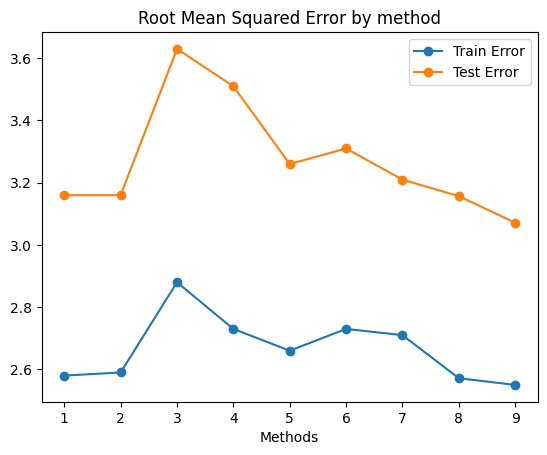

In [42]:
plt.plot(list(range(1,len(train_errors)+1)), train_errors, marker="o")
plt.plot(list(range(1,len(test_errors)+1)), test_errors, marker="o")
plt.legend(["Train Error", "Test Error"])
plt.title("Root Mean Squared Error by method")
plt.xlabel("Methods")